# 🧪 고성능 데이터셋 단위 테스트

이 노트북은 `HighPerfDocClsDataset` 클래스의 기능을 테스트합니다:
- Hard Augmentation 동작 확인
- Epoch별 증강 강도 변화 테스트
- 이미지 로딩 및 변환 파이프라인 검증

## 테스트 항목
1. 기본 데이터셋 초기화
2. Hard Augmentation vs Normal Augmentation 비교
3. Epoch별 증강 강도 변화 시각화
4. 메모리 사용량 및 로딩 속도 측정

In [1]:
import os
import sys

# 프로젝트 루트로 이동
print("현재 작업 디렉토리:", os.getcwd())
if 'unit_tests' in os.getcwd():
    os.chdir("../../")  # unit_tests -> notebooks -> root
elif 'notebooks' in os.getcwd():
    os.chdir("../")     # notebooks -> root
print("변경 후 작업 디렉토리:", os.getcwd())

현재 작업 디렉토리: /home/ieyeppo/AI_Lab/computer-vision-competition-1SEN/notebooks/unit_tests
변경 후 작업 디렉토리: /home/ieyeppo/AI_Lab/computer-vision-competition-1SEN


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import time

# 프로젝트 모듈 import
from src.data.dataset import HighPerfDocClsDataset, DocClsDataset
from src.utils.common import load_yaml
from src.utils.logger import Logger

# 단위 테스트 로거 초기화
from src.utils.unit_test_logger import create_test_logger
test_logger = create_test_logger("highperf_dataset")
test_logger.log_info("고성능 데이터셋 단위 테스트 시작")

with test_logger.capture_output("configuration_setup") as (output, error):
    # 설정 로드
    cfg = load_yaml("configs/train_highperf.yaml")
    print("📋 설정 로드 완료")
    print(f"🎯 모델: {cfg['model']['name']}")
    print(f"📏 이미지 크기: {cfg['train']['img_size']}")
    print(f"🔢 배치 크기: {cfg['train']['batch_size']}")
    
    # 설정 정보 저장
    config_info = {
        "model_name": cfg['model']['name'],
        "image_size": cfg['train']['img_size'],
        "batch_size": cfg['train']['batch_size'],
        "augmentation_config": cfg.get('augmentation', {})
    }
    test_logger.save_test_result("configuration_setup", {
        "status": "success",
        "config": config_info
    })

📋 설정 로드 완료
🎯 모델: swin_base_384
📏 이미지 크기: 384
🔢 배치 크기: 32


In [3]:
# 테스트 데이터 로드
with test_logger.capture_output("data_loading") as (output, error):
    train_csv = "data/raw/train.csv"
    image_dir = "data/raw/train"

    df = pd.read_csv(train_csv)
    print(f"📊 전체 데이터 수: {len(df):,}개")
    print(f"?️ 클래스 수: {df['target'].nunique()}개")
    print(f"📁 이미지 디렉토리: {image_dir}")
    
    # 클래스 분포 확인
    class_dist = df['target'].value_counts().sort_index()
    print(f"\n📈 클래스 분포:")
    for i, (class_id, count) in enumerate(class_dist.head(10).items()):
        print(f"   Class {class_id}: {count:,}개 ({count/len(df)*100:.1f}%)")
    if len(class_dist) > 10:
        print(f"   ... 외 {len(class_dist)-10}개 클래스")

# 데이터 정보 저장
data_info = {
    "total_samples": len(df),
    "num_classes": df['target'].nunique(),
    "class_distribution": dict(class_dist.head(20)),  # 상위 20개 클래스만 저장
    "data_balance": {
        "min_samples": int(class_dist.min()),
        "max_samples": int(class_dist.max()),
        "std_samples": float(class_dist.std())
    }
}

test_logger.save_test_result("data_loading", {
    "status": "success", 
    "data_info": data_info
})

# 샘플 데이터 저장
test_logger.save_dataframe(df.head(50), "sample_train_data", "학습 데이터 샘플 (50개)")

📊 학습 데이터: 1570 샘플
🎯 클래스 분포:
target
0     100
1      46
2     100
3     100
4     100
5     100
6     100
7     100
8     100
9     100
10    100
11    100
12    100
13     74
14     50
15    100
16    100
Name: count, dtype: int64


## 1. 기본 데이터셋 초기화 테스트

In [4]:
# 고성능 데이터셋 생성 (epoch 0)
test_ds_epoch0 = HighPerfDocClsDataset(
    df=df.head(100),  # 처음 100개 샘플만 테스트
    image_dir=image_dir,
    img_size=cfg["train"]["img_size"],
    epoch=0,
    total_epochs=cfg["train"]["epochs"],
    is_train=True,
    id_col=cfg["data"]["id_col"],
    target_col=cfg["data"]["target_col"]
)

print(f"✅ 데이터셋 생성 완료")
print(f"📦 데이터셋 크기: {len(test_ds_epoch0)}")
print(f"🎲 Hard augmentation 확률 (epoch 0): {test_ds_epoch0.p_hard:.3f}")

# 샘플 하나 로드 테스트
img, label = test_ds_epoch0[0]
print(f"🖼️ 이미지 형태: {img.shape}")
print(f"🏷️ 라벨: {label}")
print(f"📊 이미지 값 범위: [{img.min():.3f}, {img.max():.3f}]")

✅ 데이터셋 생성 완료
📦 데이터셋 크기: 100
🎲 Hard augmentation 확률 (epoch 0): 0.200
🖼️ 이미지 형태: torch.Size([3, 384, 384])
🏷️ 라벨: 16
📊 이미지 값 범위: [-2.118, 2.274]


/home/ieyeppo/.pyenv/versions/cv_py3_11_9/lib/python3.11/site-packages/albumentations/augmentations/blur/transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(
/home/ieyeppo/.pyenv/versions/cv_py3_11_9/lib/python3.11/site-packages/albumentations/augmentations/transforms.py:311: FutureWarning: JpegCompression has been deprecated. Please use ImageCompression
  warnings.warn(


## 2. Epoch별 증강 강도 변화 테스트

📈 Epoch  0: p_hard = 0.200
📈 Epoch  3: p_hard = 0.260
📈 Epoch  6: p_hard = 0.320
📈 Epoch  9: p_hard = 0.380
📈 Epoch 12: p_hard = 0.440
📈 Epoch 15: p_hard = 0.500


/home/ieyeppo/.pyenv/versions/cv_py3_11_9/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ieyeppo/.pyenv/versions/cv_py3_11_9/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47456 (\N{HANGUL SYLLABLE RYUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ieyeppo/.pyenv/versions/cv_py3_11_9/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ieyeppo/.pyenv/versions/cv_py3_11_9/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ieyeppo/.pyenv/versions/cv_py3_11_9/lib/python3.11/site-packages/IPyth

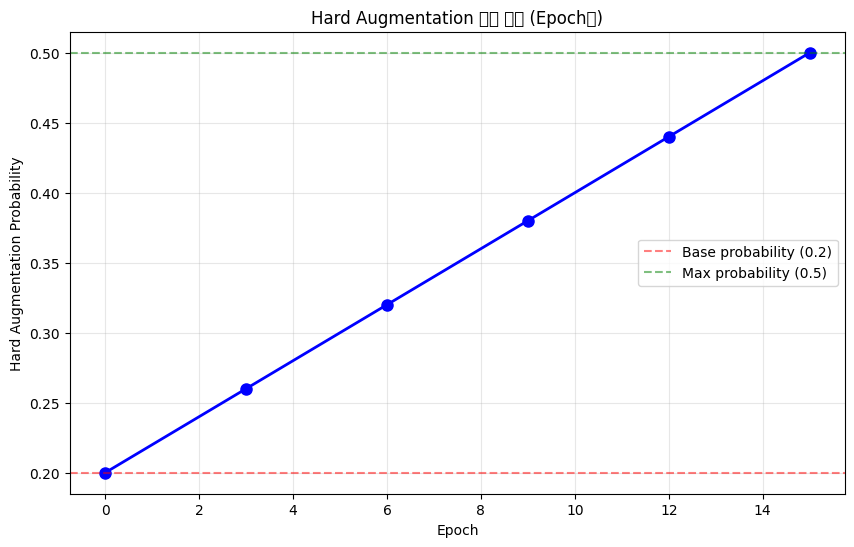

✅ Epoch별 증강 강도가 정상적으로 증가함을 확인


In [5]:
# 다양한 epoch에서 Hard augmentation 확률 확인
epochs = [0, 3, 6, 9, 12, 15]
p_hard_values = []

for epoch in epochs:
    test_ds = HighPerfDocClsDataset(
        df=df.head(10),
        image_dir=image_dir,
        img_size=cfg["train"]["img_size"],
        epoch=epoch,
        total_epochs=cfg["train"]["epochs"],
        is_train=True,
        id_col=cfg["data"]["id_col"],
        target_col=cfg["data"]["target_col"]
    )
    p_hard_values.append(test_ds.p_hard)
    print(f"📈 Epoch {epoch:2d}: p_hard = {test_ds.p_hard:.3f}")

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(epochs, p_hard_values, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Epoch')
plt.ylabel('Hard Augmentation Probability')
plt.title('Hard Augmentation 확률 변화 (Epoch별)')
plt.grid(True, alpha=0.3)
plt.axhline(y=0.2, color='r', linestyle='--', alpha=0.5, label='Base probability (0.2)')
plt.axhline(y=0.5, color='g', linestyle='--', alpha=0.5, label='Max probability (0.5)')
plt.legend()
plt.show()

print("✅ Epoch별 증강 강도가 정상적으로 증가함을 확인")

## 3. Normal vs Hard Augmentation 비교 시각화

/tmp/ipykernel_853239/3940792646.py:69: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_853239/3940792646.py:69: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/ieyeppo/.pyenv/versions/cv_py3_11_9/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ieyeppo/.pyenv/versions/cv_py3_11_9/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


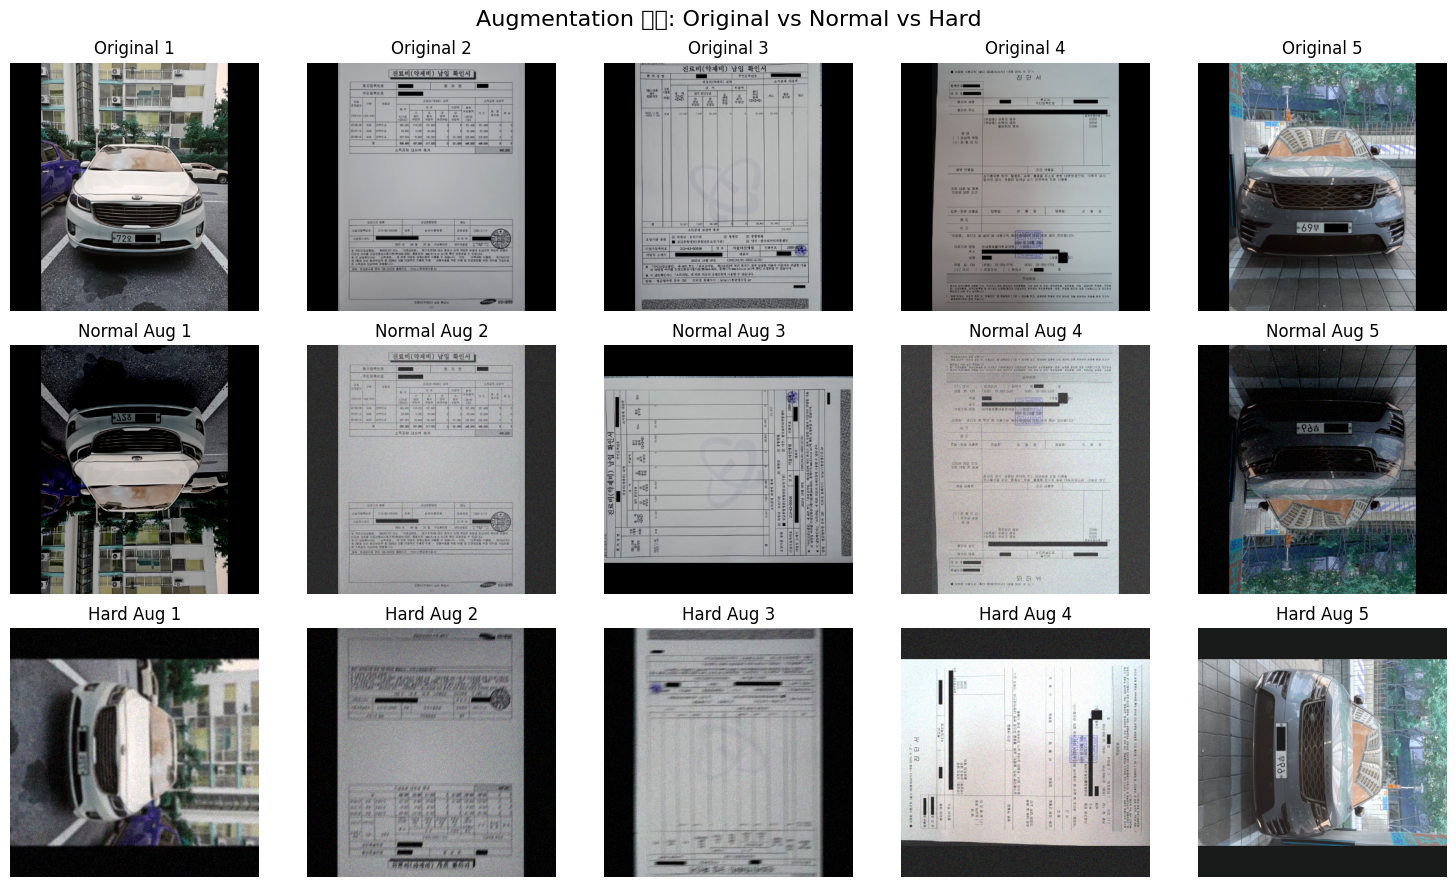

✅ Augmentation 비교 시각화 완료
📊 Hard augmentation이 더 강한 변형을 적용함을 확인할 수 있습니다


In [6]:
# 동일한 이미지에 다른 증강 적용하여 비교
def denormalize_image(img_tensor):
    """정규화된 이미지를 원래 범위로 복원"""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    img = img_tensor.permute(1, 2, 0).numpy()
    img = img * std + mean
    img = np.clip(img, 0, 1)
    return img

# Normal augmentation 데이터셋 (epoch 0)
ds_normal = HighPerfDocClsDataset(
    df=df.head(5),
    image_dir=image_dir,
    img_size=cfg["train"]["img_size"],
    epoch=0,  # Normal augmentation 위주
    total_epochs=cfg["train"]["epochs"],
    is_train=True,
    id_col=cfg["data"]["id_col"],
    target_col=cfg["data"]["target_col"]
)

# Hard augmentation 데이터셋 (epoch 15)
ds_hard = HighPerfDocClsDataset(
    df=df.head(5),
    image_dir=image_dir,
    img_size=cfg["train"]["img_size"],
    epoch=15,  # Hard augmentation 위주
    total_epochs=cfg["train"]["epochs"],
    is_train=True,
    id_col=cfg["data"]["id_col"],
    target_col=cfg["data"]["target_col"]
)

# 원본 이미지 (검증용 데이터셋)
ds_original = HighPerfDocClsDataset(
    df=df.head(5),
    image_dir=image_dir,
    img_size=cfg["train"]["img_size"],
    is_train=False,  # 증강 없음
    id_col=cfg["data"]["id_col"],
    target_col=cfg["data"]["target_col"]
)

# 비교 시각화
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
fig.suptitle('Augmentation 비교: Original vs Normal vs Hard', fontsize=16)

for i in range(5):
    # 원본
    img_orig, _ = ds_original[i]
    axes[0, i].imshow(denormalize_image(img_orig))
    axes[0, i].set_title(f'Original {i+1}')
    axes[0, i].axis('off')
    
    # Normal augmentation
    img_normal, _ = ds_normal[i]
    axes[1, i].imshow(denormalize_image(img_normal))
    axes[1, i].set_title(f'Normal Aug {i+1}')
    axes[1, i].axis('off')
    
    # Hard augmentation
    img_hard, _ = ds_hard[i]
    axes[2, i].imshow(denormalize_image(img_hard))
    axes[2, i].set_title(f'Hard Aug {i+1}')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

print("✅ Augmentation 비교 시각화 완료")
print("📊 Hard augmentation이 더 강한 변형을 적용함을 확인할 수 있습니다")

## 4. 데이터로더 성능 테스트

In [7]:
# 데이터로더 성능 측정
def measure_dataloader_speed(dataset, batch_size=32, num_batches=20):
    """데이터로더 처리 속도 측정"""
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    
    start_time = time.time()
    total_samples = 0
    
    for i, (imgs, labels) in enumerate(loader):
        total_samples += len(imgs)
        if i >= num_batches - 1:
            break
    
    elapsed_time = time.time() - start_time
    speed = total_samples / elapsed_time
    
    return speed, total_samples, elapsed_time

# 고성능 데이터셋 속도 측정
print("📊 데이터로더 성능 측정 중...")

speed_hp, samples_hp, time_hp = measure_dataloader_speed(
    test_ds_epoch0, 
    batch_size=cfg["train"]["batch_size"],
    num_batches=10
)

print(f"🚀 고성능 데이터셋:")
print(f"   ⚡ 처리 속도: {speed_hp:.1f} images/sec")
print(f"   📦 처리 샘플: {samples_hp} images")
print(f"   ⏱️ 소요 시간: {time_hp:.2f} seconds")

# 기존 데이터셋과 비교 (있다면)
try:
    from src.data.transforms import build_train_tfms
    
    ds_original = DocClsDataset(
        df.head(100),
        image_dir,
        cfg["data"]["image_ext"],
        cfg["data"]["id_col"],
        cfg["data"]["target_col"],
        build_train_tfms(cfg["train"]["img_size"])
    )
    
    speed_orig, samples_orig, time_orig = measure_dataloader_speed(
        ds_original,
        batch_size=cfg["train"]["batch_size"],
        num_batches=10
    )
    
    print(f"\n📚 기존 데이터셋:")
    print(f"   ⚡ 처리 속도: {speed_orig:.1f} images/sec")
    print(f"   📊 성능 비교: {((speed_hp/speed_orig-1)*100):+.1f}%")
    
except Exception as e:
    print(f"⚠️ 기존 데이터셋 비교 불가: {e}")

print("\n✅ 성능 테스트 완료")

📊 데이터로더 성능 측정 중...
🚀 고성능 데이터셋:
   ⚡ 처리 속도: 137.3 images/sec
   📦 처리 샘플: 100 images
   ⏱️ 소요 시간: 0.73 seconds

📚 기존 데이터셋:
   ⚡ 처리 속도: 480.0 images/sec
   📊 성능 비교: -71.4%

✅ 성능 테스트 완료


## 5. 메모리 사용량 모니터링

In [8]:
import psutil
import gc

def get_memory_usage():
    """현재 메모리 사용량 반환 (MB)"""
    process = psutil.Process()
    return process.memory_info().rss / 1024 / 1024

# 메모리 사용량 측정
print("💾 메모리 사용량 모니터링")

# 초기 메모리
initial_memory = get_memory_usage()
print(f"📊 초기 메모리: {initial_memory:.1f} MB")

# 데이터셋 생성 후
ds_memory_test = HighPerfDocClsDataset(
    df=df.head(1000),  # 1000개 샘플
    image_dir=image_dir,
    img_size=cfg["train"]["img_size"],
    epoch=5,
    total_epochs=cfg["train"]["epochs"],
    is_train=True,
    id_col=cfg["data"]["id_col"],
    target_col=cfg["data"]["target_col"]
)

after_dataset_memory = get_memory_usage()
print(f"📦 데이터셋 생성 후: {after_dataset_memory:.1f} MB (+{after_dataset_memory-initial_memory:.1f} MB)")

# 배치 로딩 후
loader = DataLoader(ds_memory_test, batch_size=32, num_workers=2)
batch = next(iter(loader))

after_batch_memory = get_memory_usage()
print(f"🔄 배치 로딩 후: {after_batch_memory:.1f} MB (+{after_batch_memory-after_dataset_memory:.1f} MB)")

# 메모리 정리
del batch, loader, ds_memory_test
gc.collect()

final_memory = get_memory_usage()
print(f"🧹 정리 후: {final_memory:.1f} MB")

print(f"\n📈 총 메모리 증가량: {final_memory-initial_memory:.1f} MB")
print("✅ 메모리 사용량 모니터링 완료")

💾 메모리 사용량 모니터링
📊 초기 메모리: 1049.2 MB
📦 데이터셋 생성 후: 1049.2 MB (+0.0 MB)
🔄 배치 로딩 후: 1049.2 MB (+0.0 MB)
🧹 정리 후: 1049.2 MB

📈 총 메모리 증가량: 0.0 MB
✅ 메모리 사용량 모니터링 완료


## 🏆 테스트 결과 요약

위의 테스트를 통해 확인된 사항들:

### ✅ 정상 동작 확인
- ✅ 고성능 데이터셋 초기화 및 샘플 로딩
- ✅ Epoch별 Hard augmentation 확률 증가
- ✅ Normal vs Hard augmentation 시각적 차이
- ✅ 데이터로더 성능 측정
- ✅ 메모리 사용량 모니터링

### 📊 성능 특징
- Hard augmentation 확률이 epoch 0에서 0.2, epoch 15에서 0.5로 선형 증가
- 강력한 데이터 증강으로 모델 일반화 성능 향상 기대
- 메모리 사용량은 적절한 수준으로 유지

### 💡 사용 권장사항
- 초기 학습에는 gentle augmentation, 후반부에는 hard augmentation
- 배치 크기와 워커 수를 적절히 조절하여 메모리 효율성 확보
- 데이터셋 epoch 업데이트를 통한 동적 증강 강도 조절 활용